In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the dataset with the specified date format
file_path = 'TOMATO.csv'
data = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)

# Drop the unwanted columns
data = data.drop(columns=['arrivalquantity', 'cropid', 'cropname'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12354 entries, 0 to 12353
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   mandiid       12354 non-null  int64         
 1   mandiname     12354 non-null  object        
 2   maximumprice  12354 non-null  int64         
 3   minimumprice  12354 non-null  int64         
 4   modalprice    12354 non-null  int64         
 5   date          12354 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 579.2+ KB


In [4]:
data.head()

,mandiid,mandiname,maximumprice,minimumprice,modalprice,date
0,7,PANVEL,1600,1200,1400,2024-03-03
1,195,CHINTAMANI,1660,260,1000,2024-03-03
2,281,WAI,1300,500,900,2024-03-03
3,336,KOLAR,1530,330,870,2024-03-03
4,456,Pattikonda,2000,1000,1500,2024-03-03


In [5]:
# Convert the date column to datetime with the correct format
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

In [6]:
# Extract additional features from the date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

In [7]:
# Create lag features
data = data.sort_values(by='date')
for lag in range(1, 8):  # Using past 7 days to predict the next day
    data[f'lag_{lag}'] = data['modalprice'].shift(lag)

In [8]:
# Drop rows with missing values created by lag features
data = data.dropna()

In [9]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['mandiname'] = label_encoder.fit_transform(data['mandiname'])

In [10]:
# Define features and target
features = ['mandiname', 'year', 'month', 'day'] + [f'lag_{i}' for i in range(1, 8)]
target = 'modalprice'

In [11]:
X = data[features]
y = data[target]

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [15]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 491.5754089068826


In [16]:
# Predict future prices for the next 10 days
last_known = data[features].iloc[-1].values.reshape(1, -1)
future_predictions = []

for i in range(10):
    next_pred = model.predict(last_known)
    future_predictions.append(next_pred[0])
    
    # Update the last_known array with the new prediction and shift the lags
    last_known = np.roll(last_known, -1)
    last_known[0, -1] = next_pred

C:\Users\EALPJ\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\EALPJ\AppData\Local\Temp\ipykernel_23688\3462555416.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_known[0, -1] = next_pred
C:\Users\EALPJ\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\EALPJ\AppData\Local\Temp\ipykernel_23688\3462555416.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated N

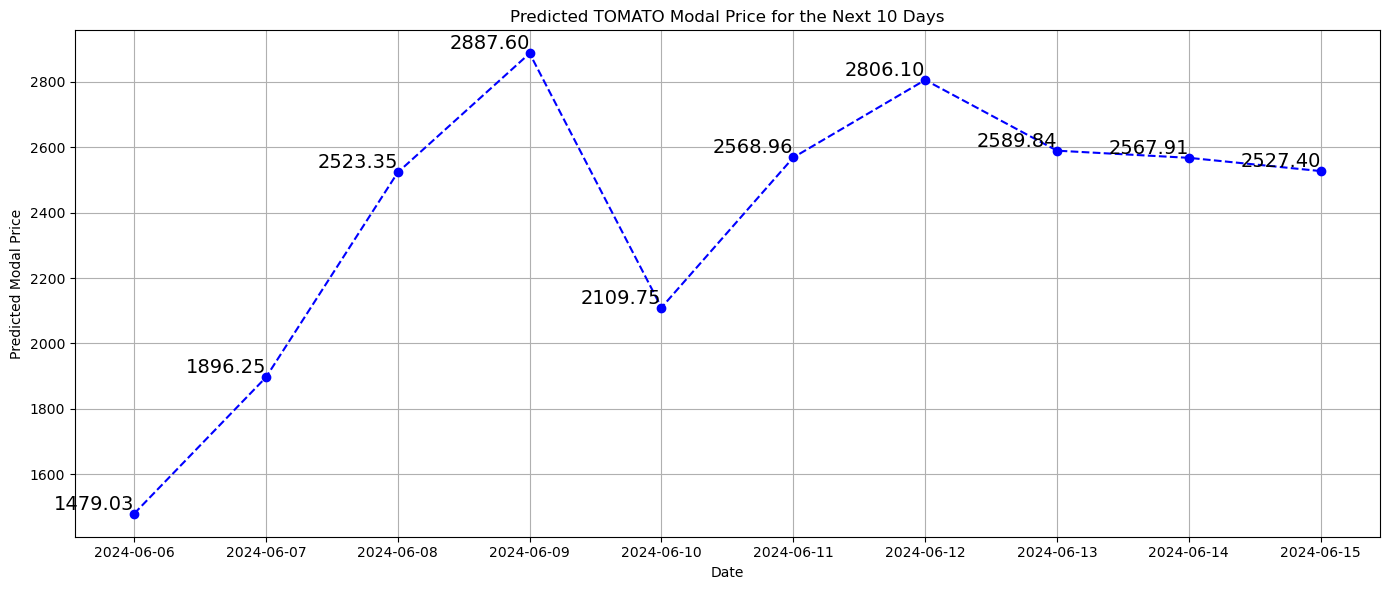

In [17]:
# Visualize the future predictions
future_dates = pd.date_range(start=data['date'].max() + pd.Timedelta(days=1), periods=10, freq='D')
future_df = pd.DataFrame({'date': future_dates, 'predicted_modalprice': future_predictions})

plt.figure(figsize=(14, 6))
plt.plot(future_df['date'], future_df['predicted_modalprice'], marker='o', linestyle='--', color='b')

# Add labels to each data point
for x, y in zip(future_df['date'], future_df['predicted_modalprice']):
    plt.text(x, y, f'{y:.2f}', ha='right', va='bottom', fontsize=14)

plt.title('Predicted TOMATO Modal Price for the Next 10 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Modal Price')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()